In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
import matplotlib
#matplotlib.use('PDF')
import matplotlib.pylab as plt
from matplotlib import rc
plt.rcParams['ps.useafm'] = True
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica Neue']}, size=13)
plt.rcParams['pdf.fonttype'] = 42
figsize,width,mec,frameon = (2,2), 1, 'none', False

In [4]:
bins = np.concatenate((np.arange(0,1000,1),np.logspace(3,10,1000)))
len(bins)

2000

Load and preprocess data

In [5]:
# don't look at distances between chromosome arms...
cytoBand = pd.read_csv('~/_Mutations/cytoBand.txt',sep='\t',header=None)  
colnames = ['Chr','Start','End','Name','Stain']
cytoBand.columns = colnames
ls = cytoBand.groupby('Chr').End.max()
# centromeres locations
cms = cytoBand.loc[cytoBand.Stain=='acen'].loc[cytoBand.Name.str.startswith('q')] # whatever is this q
cms['Middle'] = (cms.Start+cms.End)/2

In [6]:
# calculate chromosome arm lengths
lengths2 = pd.DataFrame(np.array([ls.values,[s+'arm2' for s in ls.index]]).T,columns=['Length','ChrArm'])
lengths2['Chr'] = lengths2.ChrArm.str.replace('arm2','')
lengths2.sort_values('Chr',ascending=True,inplace=True)
lengths1 = pd.DataFrame(np.array([cms.Middle.astype(int),[s+'arm1' for s in cms.Chr]]).T,columns=['Length','ChrArm'])
lengths1['Chr'] = lengths1.ChrArm.str.replace('arm1','')
lengths1.sort_values('Chr',ascending=True,inplace=True)
lengths2['Length'] = lengths2.Length.astype(int)-lengths1.Length.astype(int)
lengths = pd.concat([lengths1,lengths2],ignore_index=True)[['ChrArm','Length']].astype({'Length': int}).sort_values('Length',ascending=False).reset_index(drop=True)


Choose

In [ ]:
Tissue_CellType = 'Lung_smoker'

In [ ]:
dataset = 'Yoshida2020'
filename = '../data/{}/{}.csv.gz'.format(dataset, dataset)
df = pd.read_csv(filename)
filename = f'../data/{dataset}/{dataset}.tab.gz'
df_info = pd.read_table(filename)
dct = {'ex-smoker': 'smoker', 'non-smoker': 'never-smoker', 'smoker': 'smoker'}
df_info['Smoking'] = df_info.Status.map(dct)
df_info['Smoking'] = df_info.Tissue_CellType + '_' + df_info.Smoking
df['Tissue_CellType'] = df.Sample.map(dict(df_info[['Sample','Smoking']].values))

df = df.loc[df.Tissue_CellType==Tissue_CellType].reset_index(drop=True)
print(len(df))

skip


In [ ]:
df = pd.merge(df, cms[['Chr','Middle']], on='Chr', how='left')
df['Arm'] = np.where(df.Pos>df.Middle, 'arm2', 'arm1')
df['ChrArm'] = df.Chr + df.Arm
# Exclude acrocentric chromosomes' p arms
to_exclude = ['13arm1','14arm1','15arm1','21arm1','22arm1']
df = df.loc[~df.ChrArm.isin(to_exclude)].reset_index(drop=True)

Compute distances

In [14]:
from scipy.special import binom
from sklearn.metrics import pairwise_distances

from multiprocess import Pool,cpu_count
from tqdm import tqdm

cpus = cpu_count()-4

def applyParallel(dfGrouped, func):
    with Pool(cpus) as p:
        ret_list = list(tqdm(p.imap(func, dfGrouped),total=len(dfGrouped)))
    return pd.concat(ret_list)

def applyParallel2Array(dfGrouped, func):
    with Pool(cpus) as p:
        ret_list = list(tqdm(p.imap(func, dfGrouped),total=len(dfGrouped)))
    return np.array(ret_list)

def sample(df,n):
    return df.groupby('Chr').apply(lambda x: x.sample(n=min(n,len(x))), include_groups=False).reset_index(drop=False)

def histogram(args):
    _,df = args
    distances = np.triu(pairwise_distances(df.Pos.values.reshape(-1,1),n_jobs=1)).flatten()
    return np.histogram(distances,bins=bins,density=False)[0]

def sample2null(args,n=10000):
    group,df = args
    
    subsample = sample(df,n)
    null = histogram((None,subsample))
    null -= np.array([histogram(_) for _ in subsample.groupby(['Individual'])]).sum(axis=0)

    return null

def sample2signal(args):
    group,df = args
    
    null = np.zeros(len(bins)-1)
    null += np.array([histogram(_) for _ in df.groupby(['Individual','Sample'])]).sum(axis=0)

    return null


In [15]:
cpus = 2

In [16]:

nulls = applyParallel2Array(df.groupby(['ChrArm'],dropna=False),
                            sample2null)

signals = applyParallel2Array(df.groupby(['ChrArm'],dropna=False),
                              sample2signal)



100%|██████████| 42/42 [00:01<00:00, 22.87it/s]


/var/folders/0t/6q0byrsn7dx680k7915hp5d00000gn/T/ipykernel_20244/2184134346.py:16: RuntimeWarning: invalid value encountered in divide
  cdfs.append(row2[1:].cumsum()/row2[1:].sum())


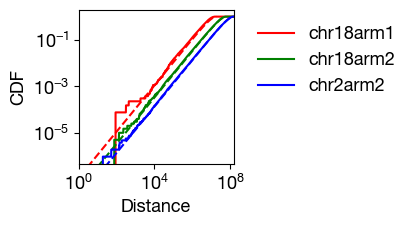

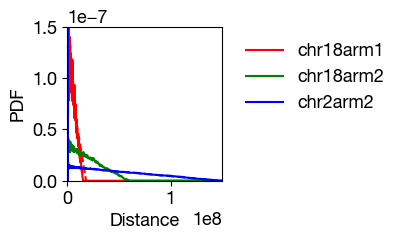

In [17]:
rs = bins[1:-1]
negs = []
cdfs = []
pdfs = []
dats = []
arms = []

arms2plot = ['chr2arm2','chr18arm2','chr18arm1']
plt.figure(figsize=figsize)
binwidths = np.diff(bins[:-1])
# plot cdfs of nulls
colors = ['r','g','b']
ii = 0
for row,row2,i in zip(nulls,signals,df.groupby(['ChrArm']).size().index):
    negs.append(row[1:].cumsum()/row[1:].sum())
    cdfs.append(row2[1:].cumsum()/row2[1:].sum())
    pdfs.append(row[1:]/row[1:].sum()/binwidths)
    dats.append(Tissue_CellType)
    arms.append(i)
    if i in arms2plot:
        c = colors[ii]
        ii += 1
        plt.plot(bins[1:-1],row[1:].cumsum()/row[1:].sum(),alpha=1,label=i,c=c)
        # plot row 2, keep same color as for row
        #plt.plot(bins[1:-1],row2[1:].cumsum()/row2[1:].sum(),c=c,alpha=0.5)
        l = lengths.loc[lengths.ChrArm==i].Length.values[0]
        r = np.arange(0,l,100)
        plt.plot(r,(r*l-r*(r+1)/2)/binom(l,2),'--',c=c)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1,1e4,1e8])
plt.xlim(1,1.5e8)
#legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',frameon=frameon)
plt.xlabel('Distance')
plt.ylabel('CDF')
plt.show()

ii = 0
plt.figure(figsize=figsize)
for row,row2,i in zip(nulls,signals,df.groupby(['ChrArm']).size().index):
    if i in arms2plot:
        c = colors[ii]
        ii += 1
        #plt.plot(bins[1:-1],row2[1:]/row2[1:].sum()/binwidths,c=c,alpha=0.5)
        plt.plot(bins[1:-1],row[1:]/row[1:].sum()/binwidths,alpha=1,label=i,c=c)
        l = lengths.loc[lengths.ChrArm==i].Length.values[0]
        r = np.arange(0,l,100)
        plt.plot(r,(l-r)/binom(l,2),'--',c=c)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1,0.05e8)
plt.xlim(1,1.5e8)
plt.xticks([1,1e8])
plt.ylim(0,1.5e-7)
#legend outside
plt.legend(frameon=frameon, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Distance')
plt.ylabel('PDF')
plt.show()

In [ ]:
from scipy.stats import nbinom 

def signal(r,n,p):
    rv = nbinom(n, p)
    return rv.cdf(r)

def noise(r,l):
    n = (r*l-r*(r+1)/2)/binom(l,2)
    return n

#def mixture(r,rho,n,p,l=l):
#    return rho*signal(r,n,p) + (1-rho)*noise(r,l)

def rescale(r: np.array, cdf: np.array, start: int = 3) -> np.array:
    if start>1: return r[start-1:],((cdf - cdf[start-2])/(1-cdf[start-2]))[start-1:]
    else: return r,cdf

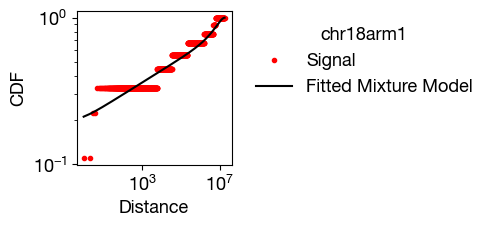

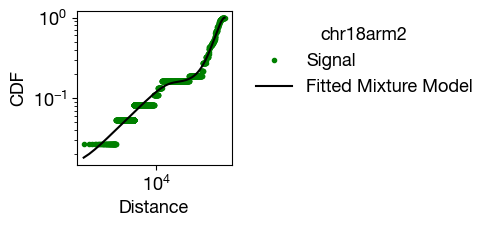

/var/folders/0t/6q0byrsn7dx680k7915hp5d00000gn/T/ipykernel_20244/365037077.py:19: RuntimeWarning: invalid value encountered in divide
  y = signal1[bins1<l].cumsum() / (signal1[bins1<l]).sum()


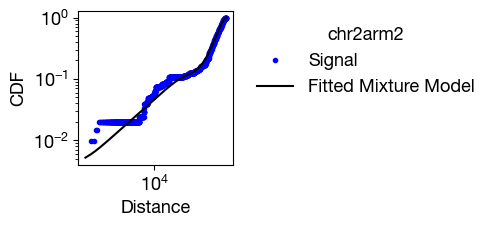

/var/folders/0t/6q0byrsn7dx680k7915hp5d00000gn/T/ipykernel_20244/365037077.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(funlog, xlog, ylog, p0=p0, maxfev=10000)


In [19]:
from scipy.optimize import curve_fit
ps = []
rhos = []
means = []
vars = []
ii=0
for j in range(len(signals)):
    i = df.groupby(['ChrArm']).size().index[j]
    l = lengths.loc[lengths.ChrArm==i].Length.values[0]
    r = np.arange(0,l,100)
    bins1 = bins[1:-1]
    signal1 = signals[j][1:]

    def mixture(r,rho,n,p,l=l):
        return rho*signal(r,n,p) + (1-rho)*noise(r,l)

    # Fit the mixture model to signals[0]
    x = bins1[bins1<l]
    y = signal1[bins1<l].cumsum() / (signal1[bins1<l]).sum()
    xlog = np.log(x[y>0])
    ylog = np.log(y[y>0])

    def funlog(x, rho, n, p):
        return np.log(mixture(np.exp(x), rho, n, p))
    p0 = [y[100], 0.2, 0.02]
    if len(ylog)>0:
        popt, pcov = curve_fit(funlog, xlog, ylog, p0=p0, maxfev=10000)
    else:
        popt = [0,0,1]

    ps.append(popt)
    if i!=arms[j]: print('wrong order!')
    else:
        rhos.append(popt[0])
        means.append(popt[1]*(1-popt[2])/popt[2])
        vars.append(popt[1]*(1-popt[2])/(popt[2]**2))

    # Plot the fitted mixture model
    if i in arms2plot:
        plt.figure(figsize=figsize)
        plt.plot(bins1[bins1<l], signal1[bins1<l].cumsum() / (signal1[bins1<l]).sum(), '.', label='Signal',color=colors[ii])
        plt.plot(bins1[bins1<l], mixture(bins1[bins1<l], *popt), 'k-', label='Fitted Mixture Model')
        #plt.plot(bins1[bins1<l], mixture(bins1[bins1<l], *p0), '-', label='Start')
        #plt.plot(bins1[bins1<l], mixture(bins1[bins1<l], *[0.02, 0.1, 0.005]), '-', label='By hand')
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel('Distance')
        plt.ylabel('CDF')
        plt.legend(title=i,frameon=frameon, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
        ii+=1
ps = np.array(ps)

In [21]:
""" TP = rho*signal(.,n,p) 
    FN = (1-rho)*noise(.,l) """ 
sens = []
prec = []
for rho,n,p in ps:
    sens.append(signal(bins,n,p))
    prec.append(rho*signal(bins,n,p)/(rho*signal(bins,n,p) + (1-rho)*noise(bins,l)))
sens = np.array(sens)
prec = np.array(prec)

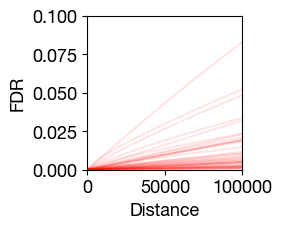

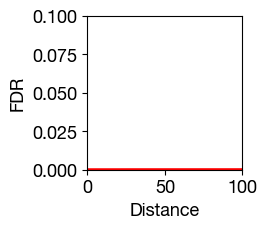

In [33]:
plt.figure(figsize=figsize)
#plt.plot(bins, sens[0])
for pi in prec:
    plt.plot(bins, 1-pi,
             color='red',alpha=0.1)
plt.ylabel('FDR')
plt.xlabel('Distance')
plt.xlim(0,1e5)
plt.ylim(0,0.1)
plt.show()

plt.figure(figsize=figsize)
#plt.plot(bins, sens[0])
for pi in prec:
    plt.plot(bins, 1-pi,
             color='red',alpha=0.1)
plt.ylabel('FDR')
plt.xlabel('Distance')
plt.xlim(0,1e2)
plt.ylim(0.,0.1)
plt.show()

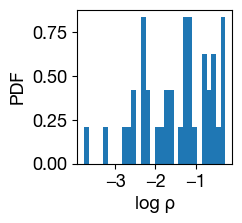

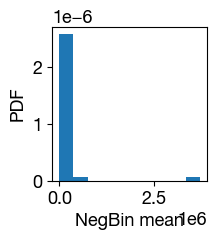

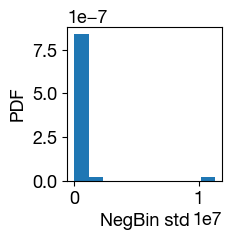

In [23]:
plt.figure(figsize=figsize)
plt.hist(np.log(ps[:,0][ps[:,0]>0]),bins=30, density=True)
plt.xlabel('log ρ')
plt.ylabel('PDF')
plt.show()

"""plt.figure(figsize=figsize)
plt.hist(ps[:,1],bins=30, density=True)
plt.xlabel('NegBin n')
plt.ylabel('PDF')
plt.show()

plt.figure(figsize=figsize)
plt.hist(np.log(ps[:,2]),bins=30, density=True)
plt.xlabel('NegBin p')
plt.ylabel('PDF')
plt.show()"""

plt.figure(figsize=figsize)
plt.hist(ps[:,1]*(1-ps[:,2])/ps[:,2],bins=10, density=True)
plt.xlabel('NegBin mean')
plt.ylabel('PDF')
plt.show()

plt.figure(figsize=figsize)
plt.hist(np.sqrt(ps[:,1]*(1-ps[:,2])/ps[:,2]/ps[:,2]),bins=10, density=True)
plt.xlabel('NegBin std')
plt.ylabel('PDF')
plt.show()



Plot SI figures

In [59]:
Tissue_CellTypes = ['Neuron','Oligo','Maternal','Paternal','Lung_never-smoker','Liver_never-smoker','Lung_smoker','Liver_smoker']
arms2plot = ['chr2arm2','chr18arm2','chr18arm1']
binwidths = np.diff(bins[:-1])

from scipy.special import binom

def signalPDF(r,n,p):
    rv = nbinom(n, p)
    return rv.pmf(r)

def noisePDF(r,l):
    n = (l-r)/binom(l,2)
    return n

from scipy.stats import nbinom 

def signal(r,n,p):
    rv = nbinom(n, p)
    return rv.cdf(r)

def noise(r,l):
    n = (r*l-r*(r+1)/2)/binom(l,2)
    return n

def mixture(r,rho,n,p,l=l):
    return rho*signal(r,n,p) + (1-rho)*noise(r,l)



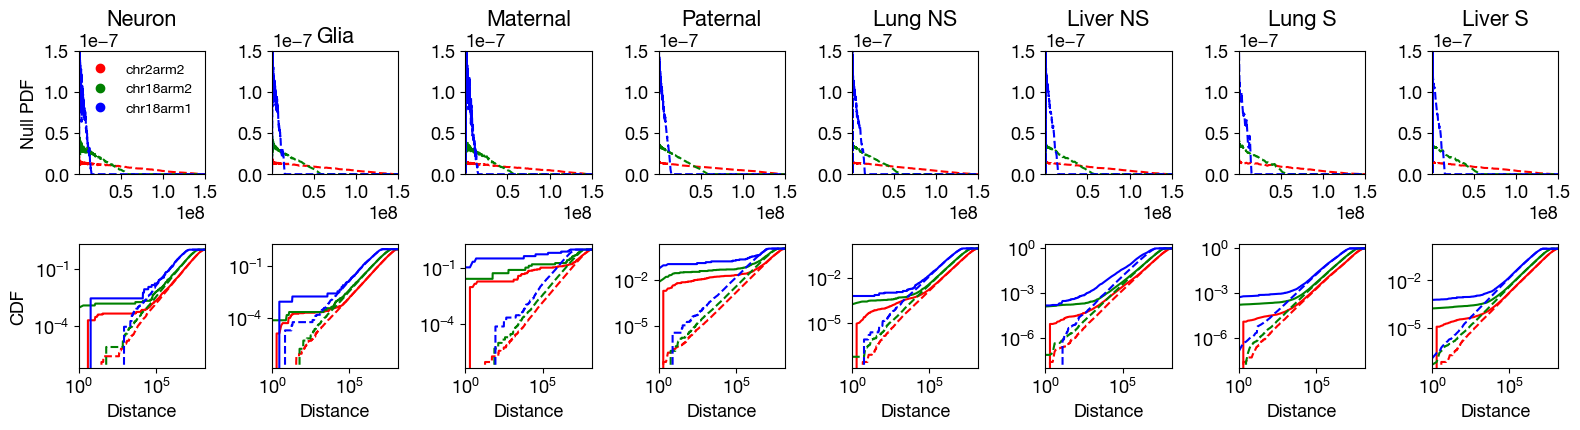

In [ ]:
#define figure with letters of subplots
dct = {'Neuron': 'Neuron', 'Oligo': 'Glia', 'Maternal': 'Maternal', 'Paternal': 'Paternal',
       'Lung_never-smoker': 'Lung NS', 'Liver_never-smoker': 'Liver NS',
       'Lung_smoker': 'Lung S', 'Liver_smoker': 'Liver S'}
xmax = 1.5e8
ymax = 1.5e-7
fig, axs = plt.subplot_mosaic("ABCDEFGH;IJKLMNOP", figsize=(16,4.5))
axs_list = list(axs.values())
for c,chrarm in zip(['r','g', 'b'], arms2plot):
    for row1ax,row2ax,tissue in zip(axs_list[:8],axs_list[8:16],Tissue_CellTypes):
        row1ax.set_title(dct[tissue])
        filename = f'../data/clusters/{tissue}_{chrarm}.csv.gz'
        output = pd.read_csv(filename, compression='gzip')

        row1ax.plot(output.Distance, output.SignalPDF, '--', color=c)   
        row1ax.set_xlim(1, xmax)
        row1ax.set_ylim(0, ymax)
        if row1ax in [axs['A'], axs['I']]: 
            row1ax.set_ylabel('Null PDF')
            if tissue=='Neuron': 
                row1ax.plot(-1,-1, 'o', color=c,label=chrarm)   
                row1ax.legend(frameon=frameon, loc='upper right', fontsize=10)

        row2ax.plot(output.Distance, output.NullCDF, '--', color=c)   
        row2ax.plot(output.Distance, output.SignalCDF, '-', color=c)   
        row2ax.set_xscale('log')
        row2ax.set_yscale('log')
        row2ax.set_xlim(1, xmax)
        row2ax.set_ylim(ymax=2)
        if row2ax in [axs['A'], axs['I']]: row2ax.set_ylabel('CDF')

        """row3ax.plot(output.Distance, output.NullCDFRatio*0+1, 'k--')   
        row3ax.plot(output.Distance, output.SignalCDFRatio/output.NullCDFRatio, '-', color=c)
        row3ax.set_xscale('log')
        row3ax.set_yscale('log')
        row3ax.set_xlim(1, xmax)
        row3ax.set_ylim(0.1,1e5)
        if row3ax in [axs['A'], axs['I'], axs['R']]: row3ax.set_ylabel('CDF / Null')"""
for ax in axs_list[::-1][:8]:
    ax.set_xlabel('Distance')
plt.tight_layout()
#plt.savefig('sup_pdfs/clusters_distances.pdf', bbox_inches='tight')
plt.show()

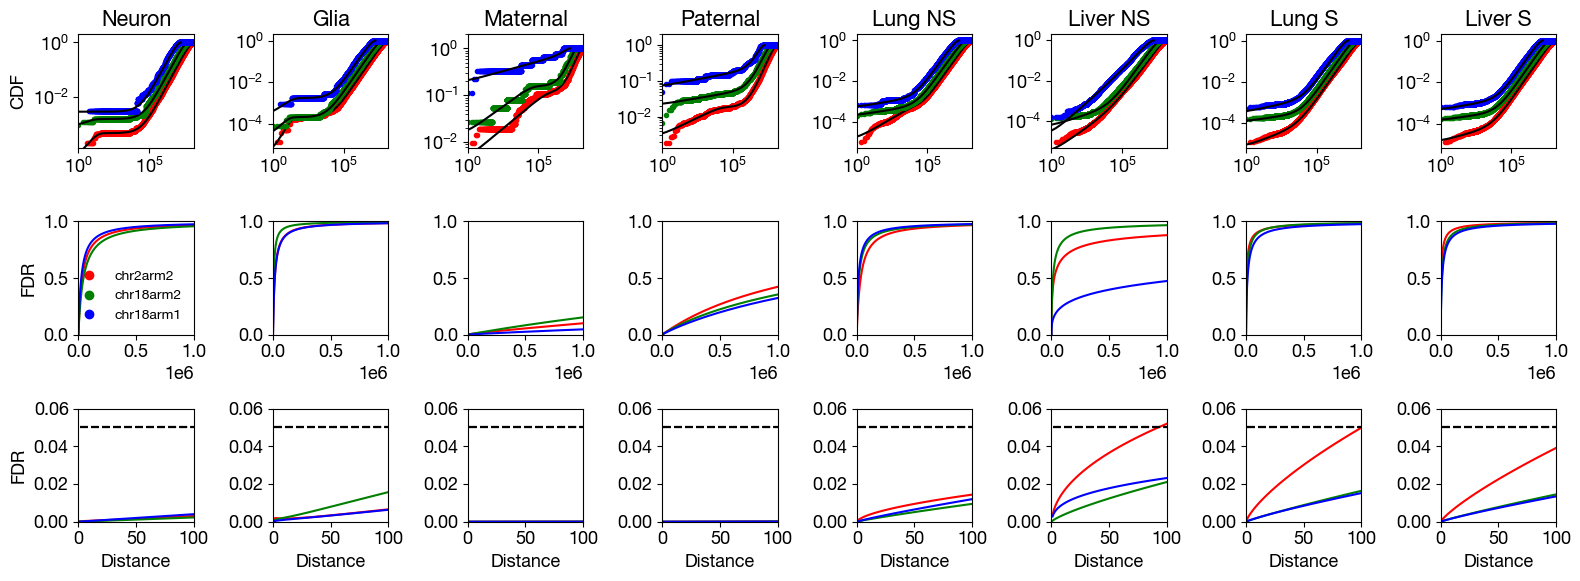

In [ ]:
#define figure with letters of subplots
dct = {'Neuron': 'Neuron', 'Oligo': 'Glia', 'Maternal': 'Maternal', 'Paternal': 'Paternal',
       'Lung_never-smoker': 'Lung NS', 'Liver_never-smoker': 'Liver NS',
       'Lung_smoker': 'Lung S', 'Liver_smoker': 'Liver S'}
xmax = 1.5e8
ymax = 1.5e-7
fig, axs = plt.subplot_mosaic("ABCDEFGH;IJKLMNOP;RSTUVWXY", figsize=(16,6))
axs_list = list(axs.values())
for c,chrarm in zip(['r','g', 'b'], arms2plot):
    for row1ax,row2ax,row3ax,tissue in zip(axs_list[:8],axs_list[8:16],axs_list[16:24],Tissue_CellTypes):
        row1ax.set_title(dct[tissue])
        filename = f'../data/clusters/{tissue}_{chrarm}.csv.gz'
        output = pd.read_csv(filename, compression='gzip')
        row1ax.plot(output.Distance, output.SignalCDF, '.',color=c)
        row1ax.set_xscale('log')
        row1ax.set_yscale('log')
        row1ax.set_xlim(1, xmax)
        row1ax.set_ylim(ymax=2)
        rho = output.Prevalence[0]
        m = output.Mean[0]
        v = output.Variance[0]
        p = m/v
        n = m*p/(1-p)
        l = lengths.loc[lengths.ChrArm==chrarm].Length.values[0]
        popt = [rho,n,p,l]
        mask = output.Distance<l
        row1ax.plot(output.Distance[mask], mixture(output.Distance, *popt)[mask], 'k-')
        if row1ax in [axs['A'], axs['I'], axs['R']]: 
            row1ax.set_ylabel('CDF')
            if tissue=='Neuron': 
                row2ax.plot(-1,-1, 'o', color=c,label=chrarm)   
                row2ax.legend(frameon=frameon, loc='lower right', fontsize=10)
                
        row2ax.plot(output.Distance, (1-rho)*noise(output.Distance,l)/(rho*signal(output.Distance,n,p) + (1-rho)*noise(output.Distance,l)), '-', color=c)   
        #row2ax.set_xscale('log')
        #row2ax.set_yscale('log')
        row2ax.set_xlim(0, 1000000)
        row2ax.set_ylim(0,1)
        if row2ax in [axs['A'], axs['I'], axs['R']]: row2ax.set_ylabel('FDR')

        #sens.append(signal(bins,n,p))
        #prec.append(rho*signal(bins,n,p)/(rho*signal(bins,n,p) + (1-rho)*noise(bins,l)))
        row3ax.plot(output.Distance, (1-rho)*noise(output.Distance,l)/(rho*signal(output.Distance,n,p) + (1-rho)*noise(output.Distance,l)), '-', color=c)   
        row3ax.plot(output.Distance, output.Distance*0+0.05, 'k--')
        #row2ax.set_xscale('log')
        #row2ax.set_yscale('log')
        row3ax.set_xlim(0, 100)
        row3ax.set_ylim(0,0.06)
        if row3ax in [axs['A'], axs['I'], axs['R']]: row3ax.set_ylabel('FDR')
for ax in axs_list[::-1][:8]:
    ax.set_xlabel('Distance')
plt.tight_layout()
#plt.savefig('sup_pdfs/clusters_fit.pdf', bbox_inches='tight')
plt.show()

0      chr2arm2
1      chr4arm2
2      chr5arm2
3      chr1arm1
4      chr1arm2
5      chr6arm2
6      chr3arm2
7      chr8arm2
8      chr7arm2
9     chr12arm2
10    chr13arm2
11     chr2arm1
12    chr10arm2
13     chrXarm2
14     chr3arm1
15     chr9arm2
16    chr14arm2
17    chr15arm2
18    chr11arm2
19     chr6arm1
20     chrXarm1
21     chr7arm1
22    chr18arm2
23    chr17arm2
24    chr11arm1
25    chr16arm2
26     chr4arm1
27     chr9arm1
28     chr5arm1
29     chr8arm1
30     chrYarm2
31    chr10arm1
32    chr16arm1
33    chr12arm1
34    chr22arm2
35    chr20arm2
36    chr21arm2
37    chr19arm2
38    chr20arm1
39    chr19arm1
40    chr17arm1
41    chr15arm1
42    chr13arm1
43    chr14arm1
44    chr18arm1
45    chr22arm1
46    chr21arm1
47     chrYarm1
Name: ChrArm, dtype: object

In [76]:
np.logspace(-10, 0, 20)

array([1.00000000e-10, 3.35981829e-10, 1.12883789e-09, 3.79269019e-09,
       1.27427499e-08, 4.28133240e-08, 1.43844989e-07, 4.83293024e-07,
       1.62377674e-06, 5.45559478e-06, 1.83298071e-05, 6.15848211e-05,
       2.06913808e-04, 6.95192796e-04, 2.33572147e-03, 7.84759970e-03,
       2.63665090e-02, 8.85866790e-02, 2.97635144e-01, 1.00000000e+00])

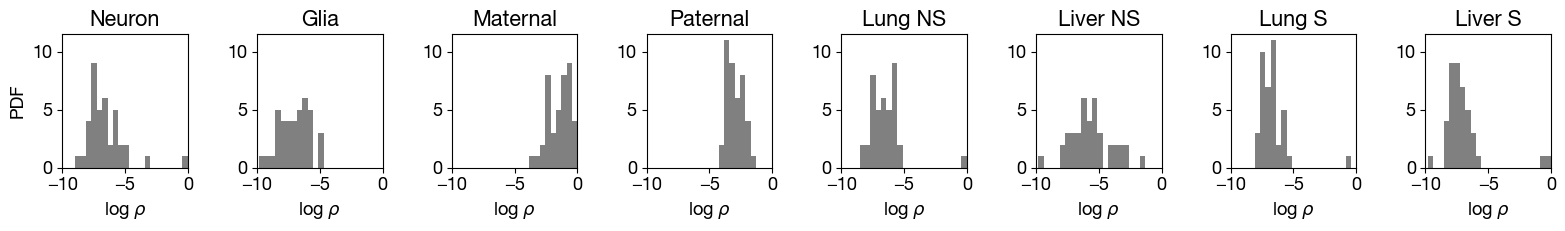

In [90]:
fig, axs = plt.subplot_mosaic("ABCDEFGH", figsize=(16,2.5))
axs_list = list(axs.values())
for row1ax,tissue in zip(axs_list,Tissue_CellTypes):
    row1ax.set_title(dct[tissue])
    rhos = []
    for chrarm in lengths.ChrArm:
        filename = f'../data/clusters/{tissue}_{chrarm}.csv.gz'
        #check if file exists
        if os.path.exists(filename):
            output = pd.read_csv(filename, compression='gzip')
            rhos.append(output.Prevalence[0])
        #else: print(filename)
    rhos = np.array(rhos)
    h,b = np.histogram(np.log(rhos[rhos>0]), bins=np.log(np.logspace(-10, 0, 55)))
    row1ax.bar(b[:-1], h, width=np.diff(b), align='edge', color='gray')
    row1ax.set_xlim(-10,0)
    row1ax.set_ylim(0,11.5)
    if row1ax in [axs['A']]: row1ax.set_ylabel('PDF')
    row1ax.set_xlabel(r'log $\rho$')
plt.tight_layout()
plt.savefig('sup_pdfs/clusters_prevalences.pdf', bbox_inches='tight')
plt.show()

Addendum

In [14]:
from tools import COSMIC
cosmic = COSMIC()

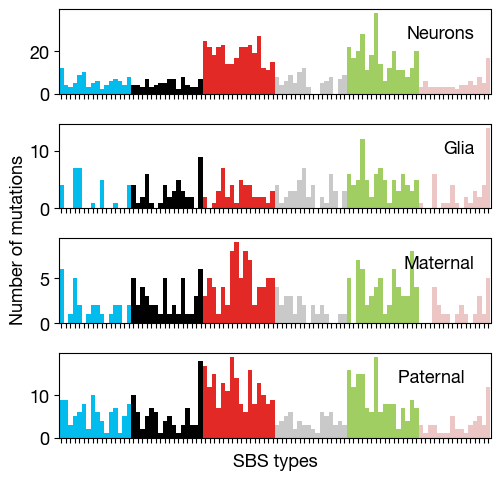

In [ ]:
# make histogram of types in cosmic.order from df.Type
dataset = 'Miller2022'
filenames = ['../data/Miller2022/Miller2022-clustered.csv.gz',
             '../data/Ganz2024/Ganz2024-clustered.csv.gz',
             '../data/Germline/Germline_maternal-clustered.csv.gz',
             '../data/Germline/Germline_paternal-clustered.csv.gz']
labels = ['Neurons','Glia','Maternal','Paternal  ']
fig = plt.figure(figsize=(5,5))
subplot = 411
for label,filename in zip(labels,filenames):
    df = pd.read_csv(filename)
    proba = df.Type.value_counts().reindex(cosmic.order).values
    ax = fig.add_subplot(subplot)
    subplot += 1
    delta = len(cosmic.order)//len(cosmic.colors)
    x = np.arange(delta)   
    for i in range(6):
        ax.bar(x+i*delta,proba[i*delta:(i+1)*delta],
                color=cosmic.colors[i],width=width)
    ax.set_xlim(-width/2,len(cosmic.order)-width/2)
    ax.set_ylim(ymin=0)
    ax.set_xticks(range(len(cosmic.order)))
    ax.set_xticklabels(['' for _ in cosmic.contexts],rotation=90)  
    ax.legend([],title=label,frameon=False,loc=1)
ax.set_xlabel('SBS types')# add common ylabel to all 4 plots
# add shared y axis label
fig.text(0., 0.5, 'Number of mutations', va='center', rotation='vertical')
plt.tight_layout()
#plt.savefig(f'sup_pdfs/clusters_types.pdf', bbox_inches='tight')
plt.show()


In [35]:
subplot

145

In [ ]:
Addendum    def plot(self,proba,
             save=None,
             title=None,
             show_letters=False,
             figsize=(6,2),
             width=1):
        """ COSMIC-like plot """
